# Competitive Balance in the NHL

WORK-IN-PROGRESS

## TL;DR

### Question

>Did the 2004-2005 lockout, and subsequent changes, impact the competitive balance of the NHL for the better?

### Approach

>Compare 1979-2004 seasons (expansion eras) to the 2006-2021 seasons (post lockout) using within-season variance as a proxy for competitive balance and a permuation test for significant difference.

### Results

>Competitive balance significantly decreased from XX to YY (a relative improvement of Z%).

## Question

Our goal of this analysis is to understand if the 2004-2005 lockout, and subsequent changes to the CBA and league rules, impacted the competitive balance of the NHL. We will tackle an important highlights of the pre and post periods for our analysis, how we will define competitive balance quantitatively, and if the difference between eras is statistically significant. 

Ultimately, we want to answer the question: 

>Did the 2004-2005 lockout, and subsequent changes, impact the competitive balance of the NHL for the better?

### Pre and Post Periods

__Expansion Eras: 1979-1980 to 2003-2004__

Major highlights.

__Post Lockout Era: 2005-2006 to 2020-2021__

Major rule changes. 

### Competitive Balance

+ Within-season variation
+ HHI (will this fail with teams moving in and out?)

### Statistical Significance

Permuation test

## Data

We are querying the history of the NHL standings using a helper function that connects to the NHL stats API. There isn't a ton of documentation, but this [repo](https://github.com/dword4/nhlapi) is a great place to start for understanding what is available. 

First we use a function to query the games played (GP) and point percentage for each team in a single season , and then we iterate through each season in history using that function to collect all historical results. 

### NHL API Call

In [1]:
import requests
from tqdm import tqdm
import pandas as pd


def fetch_season_summary(season: str):
    """
    Query team standings for a given season.
    """
    # dictionary holder for the season
    season_standings = dict()

    # api request
    base_url = 'https://statsapi.web.nhl.com/api/v1/standings/byLeague'
    season_id = f'?season={season}'
    season = requests.get(base_url + season_id)
    # throws an error for the missing lockout season
    try:
        season_records = season.json()['records'][0]

        # extract results
        season_standings['season'] = season_records['season']
        season_standings['num_teams'] = len(season_records['teamRecords'])
        results = [{
            'team': team['team']['name'],
            'gp': team['gamesPlayed'],
            'points': team['points'],
            'points_pct': team['pointsPercentage']
        } for team in season_records['teamRecords']
        ]
        season_standings['standings_df'] = pd.DataFrame(results)
        return season_standings
    except Exception:
        pass


def fetch_season_history(start_season='19171918', end_season='20202021'):
    """
    Query team standings for every season between start_season and end_season
    (inclusive)
    """
    # convert to ints for incrementing after each loop
    start_season_start = int(start_season[:4])
    start_season_end = int(start_season[-4:])
    end_season_start = int(end_season[:4])
    current_start = start_season_start
    current_end = start_season_end
    all_seasons = list()
    for _ in tqdm(range(start_season_start, end_season_start + 1)):
        season = str(current_start) + str(current_end)
        season_dict = fetch_season_summary(season)
        if season_dict is not None:
            all_seasons.append(season_dict)
        current_start += 1
        current_end += 1
    return all_seasons

In [2]:
all_seasons = fetch_season_history('19171918', '20202021')

100%|██████████| 104/104 [00:06<00:00, 16.24it/s]


The innagural NHL season was in 1917-1918 with four teams. We can see the results below. 

In [3]:
# list of dict for each season
all_seasons[0]

{'season': '19171918',
 'num_teams': 4,
 'standings_df':                      team  gp  points  points_pct
 0      Montréal Canadiens  22      26    0.590909
 1          Toronto Arenas  22      26    0.590909
 2  Ottawa Senators (1917)  22      18    0.409091
 3      Montreal Wanderers   6       2    0.166667}

Despite our progress bar showing 104 seasons, we only have 103 for analysis as the 2004-2005 season was lost due to a lockout. 

In [4]:
print(f'Total seasons: {len(all_seasons)}')

Total seasons: 103


### Competitive Balance

There are two metrics we will use to analyze competitive balance:

1. Within-season variation (regular season)
2. HHI (championships)

In [5]:
import numpy as np

def calculate_within_season_var(standings_df: pd.DataFrame):
    """
    Calculate competitive balance for the season. This assumes that the ideal
    point percentage is the average point percentage for the season, which may
    not be 0.5.
    """
    actual_std = standings_df.points_pct.std(ddof=0)
    # weighted average to account for differences in games played
    point_pct_avg = standings_df.points.sum() / (standings_df.gp.sum() * 2)
    gp = standings_df.gp.mean()
    ideal_std = np.sqrt((point_pct_avg * (1-point_pct_avg))) / np.sqrt(gp)
    return {
        'gp': gp,
        'point_pct_avg': point_pct_avg,
        'actual_std': actual_std,
        'ideal_std': ideal_std,
        'ratio': actual_std / ideal_std
    }

For each iteration in the list comprehension, we extract the season label and then unpack the competitive balance dictionary result. The results for each season are stored as a pandas dataframe. 

In [6]:
competitive_balance_df = pd.DataFrame([
    {
        'season': season['season'],
        'num_teams': season['num_teams'],
        **calculate_within_season_var(season['standings_df'])
    }
    for season in all_seasons
])

In [7]:
competitive_balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         103 non-null    object 
 1   num_teams      103 non-null    int64  
 2   gp             103 non-null    float64
 3   point_pct_avg  103 non-null    float64
 4   actual_std     103 non-null    float64
 5   ideal_std      103 non-null    float64
 6   ratio          103 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.8+ KB


We can see the first few seasons had very little teams and games played. 

In [8]:
competitive_balance_df.head()

,season,num_teams,gp,point_pct_avg,actual_std,ideal_std,ratio
0,19171918,4,18.0,0.5,0.174078,0.117851,1.477098
1,19181919,3,18.0,0.5,0.163551,0.117851,1.387777
2,19191920,4,24.0,0.5,0.222439,0.102062,2.179449
3,19201921,4,24.0,0.5,0.147314,0.102062,1.443376
4,19211922,4,24.0,0.5,0.125865,0.102062,1.233221


The most recent seasons were cut short due to COVID-19 and had a higher average points percentage due to points for overtime losses. 

In [9]:
competitive_balance_df.tail()

,season,num_teams,gp,point_pct_avg,actual_std,ideal_std,ratio
98,20162017,30,82.000000,0.558740,0.090735,0.054833,1.654746
99,20172018,31,82.000000,0.558222,0.092602,0.054840,1.688573
100,20182019,31,82.000000,0.553304,0.081895,0.054901,1.491679
101,20192020,31,69.806452,0.557763,0.084668,0.059444,1.424336
102,20202021,31,56.000000,0.556164,0.115598,0.066392,1.741138


### Analysis Periods

In [10]:
def assign_period(season):
    if season < '19791980':
        return 'other'
    elif season < '20052006':
        return 'expansion'   
    else:
        return 'post-lockout'
    
competitive_balance_df['period'] = competitive_balance_df.season.apply(assign_period)

Using our defined periods, we have 25 expansion era seasons and 16 post-lockout seasons.

In [11]:
def summary(x):
    results = {
        'seasons': x.season.count(),
        'teams': x.num_teams.mean(),
        'point_pct_avg': x.point_pct_avg.mean(),
        'ratio': x.ratio.mean()
    }
    return pd.Series(results)


competitive_balance_df.groupby('period').apply(summary)

,seasons,teams,point_pct_avg,ratio
period,,,,
expansion,25.0,24.120000,0.505425,1.856610
other,62.0,8.258065,0.500000,1.846821
post-lockout,16.0,30.250000,0.558143,1.535151


## Exploration

To facilitate plotting, we'll extract the last 4 characters from the `season` variable to represent the year. 

In [12]:
competitive_balance_df['year'] = competitive_balance_df['season'].str[-4:].astype(int)

### Historical Competitive Balance

First, we'll take a look at how competitive balance has changed throughout the history of the leauge. 

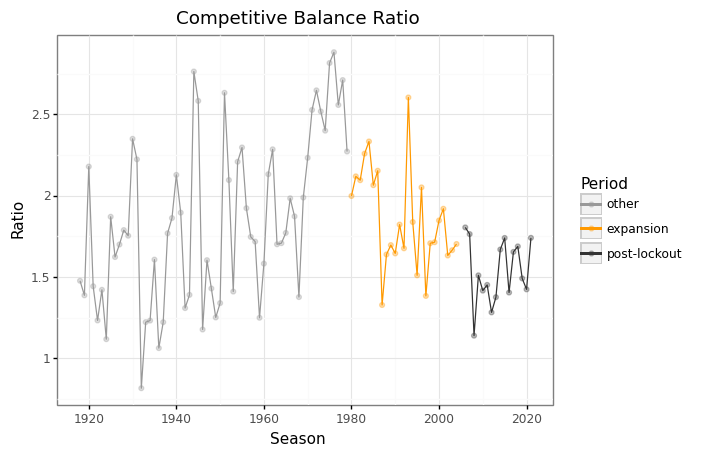

<ggplot: (8772941740990)>

In [13]:
import plotnine as p9

historical_pl(
    p9.ggplot(competitive_balance_df, p9.aes('year', 'ratio', color='period'))
    + p9.geom_point(alpha=1/3)
    + p9.geom_line()
    + p9.scale_x_continuous(breaks=np.arange(1920, 2021, 20))
    + p9.scale_color_manual(
        breaks=['other', 'expansion', 'post-lockout'],
        values=['#999999', '#FF9900', '#333333']
    )
    + p9.labs(
        title='Competitive Balance Ratio',
        x='Season',
        y='Ratio',
        color='Period'
    )
    + p9.guides(
        
    )
    + p9.theme_bw()
)

### Expansion Era vs. Post-Lockout

Let's zoom in on the two periods of interest. 

In [14]:
analysis_df = competitive_balance_df.query('season > "19781989"')

# extract means
expansion = analysis_df.query('period == "expansion"').ratio.values
post_lockout = analysis_df.query('period == "post-lockout"').ratio.values

print('Competitive Balance Ratio')
print('-' * 25)
print(f'Expansion: {expansion.mean():.2F} ({expansion.std():.2F})')
print(f'Post-Lockout: {post_lockout.mean():.2F} ({post_lockout.std():.2F})')

Competitive Balance Ratio
-------------------------
Expansion: 1.86 (0.30)
Post-Lockout: 1.54 (0.19)


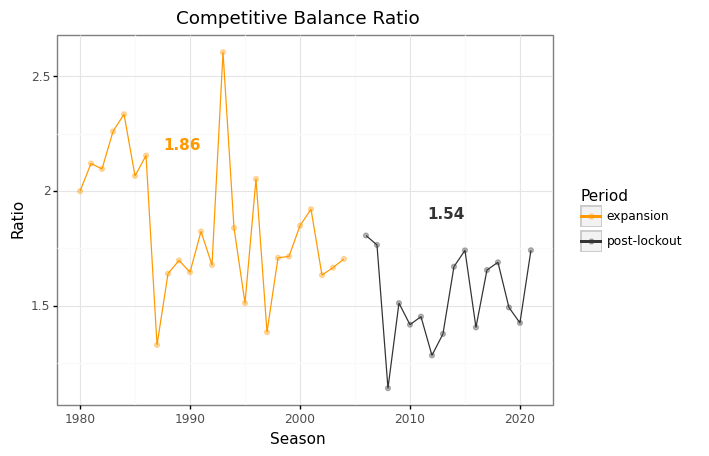

In [40]:
analysis_plot = (
    p9.ggplot(analysis_df, p9.aes('year', 'ratio', color='period'))
    + p9.geom_point(alpha=1/3)
    + p9.geom_line()
    + p9.scale_x_continuous(breaks=np.arange(1920, 2021, 10))
    + p9.scale_color_manual(
        breaks=['expansion', 'post-lockout'],
        values=['#FF9900', '#333333']
    )
    + p9.labs(
        title='Competitive Balance Ratio',
        x='Season',
        y='Ratio',
        color='Period'
    )
    + p9.annotate(
        'text',
        x=1991,
        y=2.2,
        label=f'{expansion.mean():.2F}',
        fontweight='bold',
        ha='right',
        size=11,
        color='#FF9900'
    )
    + p9.annotate(
        'text',
        x=2015,
        y=1.9,
        label=f'{post_lockout.mean():.2F}',
        fontweight='bold',
        ha='right',
        size=11,
        color='#333333'
    )
    + p9.theme_bw()
)

analysis_plot.draw();

## Modeling

https://matthew-brett.github.io/cfd2019/chapters/05/permutation_and_t_test

+ Permuatation test for within-season variance
+ permuation test for HHI

1. Function to calculate metric (HHI only)
2. Observed difference
3. Combine arrays
4. Permute and caculate
5. Analyze distribution

### Permutation Test

In [16]:
observed_difference = post_lockout.mean() - expansion.mean()
print(f'Observed Difference: {observed_difference:.2F}')

Observed Difference: -0.32


In [17]:
def permutation_test(samples_a, samples_b, n_iters=10000):
    pooled = np.append(samples_a, samples_b)
    random_differences = np.zeros(n_iters)
    N_b = samples_b.size
    for i in range(n_iters):
        np.random.shuffle(pooled)
        random_differences[i] = np.mean(pooled[:N_b]) - np.mean(pooled[N_b:])
    return pd.DataFrame(dict(difference=random_differences))

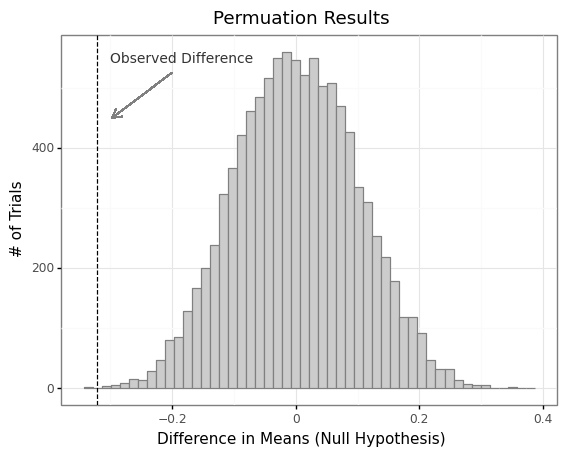

In [39]:
np.random.seed(90)

perm_test_df = permutation_test(expansion, post_lockout)

perm_plot = (
    p9.ggplot(perm_test_df, p9.aes('difference'))
    + p9.geom_histogram(bins=50, fill='#CCCCCC', color='grey')
    + p9.geom_vline(xintercept=observed_difference, linetype='dashed')
    +p9.labs(
        title='Permuation Results',
        x='Difference in Means (Null Hypothesis)',
        y='# of Trials'
    )
    + p9.theme_bw()
    + p9.annotate(
        'text',
        x=-0.3,
        y=550,
        label='Observed Difference',
        ha='left',
        size=10,
        color='#333333'
    )
    + p9.geom_segment(
        x =-0.2,
        y=525, 
        xend=observed_difference+0.025,
        yend=450,
        color='grey',
        alpha=0.75,
        arrow=p9.arrow(angle=30, length=0.1, ends='last', type='open'),
    )
)

perm_plot.draw();

In [20]:
# two-sided test
p_val = np.mean(perm_test_df.difference.abs() >= np.abs(observed_difference))
print('Under the Null Hypothesis:')
print(f'The probability of a difference as extreme or more is {p_val}')

Under the Null Hypothesis:
The probability of a difference as extreme or more is 0.0006


## Results

Summarize the findings